<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/variational_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder

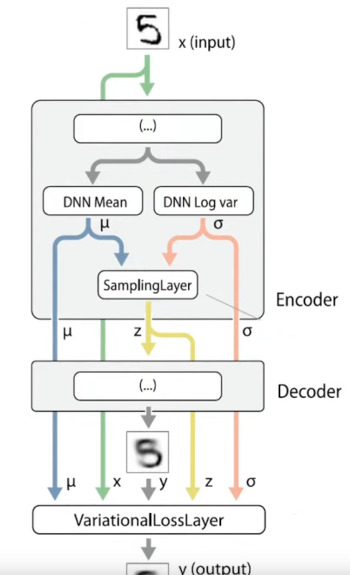

## Import

In [16]:
import os
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras import layers
from keras.callbacks import ModelCheckpoint


## Parameters

In [17]:
latent_dim   = 2
loss_weights = [1, .01]
batch_size   = 64
epochs       = 20

## Dataset

In [18]:
## MNIST, 60K train img of hand writted numbers, 10K test img

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [19]:
# Normalize

train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)

## Model

In [20]:
# CUSTOM LAYER

class SamplingLayer(keras.layers.Layer):
    '''A custom layer that receive (z_mean, z_var) and sample a z vector'''

    def call(self, inputs):
        
        z_mean, z_log_var = inputs
        
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        return z

In [21]:
# ENCODER

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()

In [22]:
# DECODER


inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()

In [23]:
# VARIATIONAL AUTO ENCODER

class VAE(keras.Model):
    '''
    A VAE model, built from given encoder and decoder
    '''

    version = '1.4'

    def __init__(self, encoder=None, decoder=None, loss_weights=[1,1], **kwargs):
        '''
        VAE instantiation with encoder, decoder and r_loss_factor
        args :
            encoder : Encoder model
            decoder : Decoder model
            loss_weights : Weight of the loss functions: reconstruction_loss and kl_loss
            r_loss_factor : Proportion of reconstruction loss for global loss (0.3)
        return:
            None
        '''
        super(VAE, self).__init__(**kwargs)
        self.encoder      = encoder
        self.decoder      = decoder
        self.loss_weights = loss_weights

        
    def call(self, inputs):
        '''
        When we use our model
        args:
            inputs : Model inputs
        return:
            output : Output of the model 
        '''
        z_mean, z_log_var, z = self.encoder(inputs)
        output               = self.decoder(z)
        return output
                
        
    def train_step(self, input):
        '''
        Implementation of the training update.
        Receive an input, compute loss, get gradient, update weights and return metrics.
        Here, our metrics are loss.
        args:
            inputs : Model inputs
        return:
            loss    : Total loss
            r_loss  : Reconstruction loss
            kl_loss : KL loss
        '''
        
        # ---- Get the input we need, specified in the .fit()
        #
        if isinstance(input, tuple):
            input = input[0]
        
        k1,k2 = self.loss_weights
        
        # ---- Forward pass
        #      Run the forward pass and record 
        #      operations on the GradientTape.
        #
        with tf.GradientTape() as tape:
            
            # ---- Get encoder outputs
            #
            z_mean, z_log_var, z = self.encoder(input)
            
            # ---- Get reconstruction from decoder
            #
            reconstruction       = self.decoder(z)
         
            # ---- Compute loss
            #      Reconstruction loss, KL loss and Total loss
            #
            reconstruction_loss  = k1 * tf.reduce_mean( keras.losses.binary_crossentropy(input, reconstruction) )

            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -tf.reduce_mean(kl_loss) * k2

            total_loss = reconstruction_loss + kl_loss

        # ---- Retrieve gradients from gradient_tape
        #      and run one step of gradient descent
        #      to optimize trainable weights
        #
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss":     total_loss,
            "r_loss":   reconstruction_loss,
            "kl_loss":  kl_loss,
        }
    
    
    def predict(self,inputs):
        '''Our predict function...'''
        z_mean, z_var, z  = self.encoder.predict(inputs)
        outputs           = self.decoder.predict(z)
        return outputs

        
    def save(self,filename, *args, **kwargs):
        '''Save model in 2 part'''
        filename, extension = os.path.splitext(filename)
        self.encoder.save(f'{filename}-encoder.h5')
        self.decoder.save(f'{filename}-decoder.h5')

    
    def reload(self,filename):
        '''Reload a 2 part saved model.'''
        filename, extension = os.path.splitext(filename)
        self.encoder = keras.models.load_model(f'{filename}-encoder.h5', custom_objects={'SamplingLayer': SamplingLayer})
        self.decoder = keras.models.load_model(f'{filename}-decoder.h5')
        print('Reloaded.')
                
        
    @classmethod
    def about(cls):
        '''Basic whoami method'''
        print('Version              :', cls.version)
        print('TensorFlow version   :', tf.__version__)
        print('Keras version        :', tf.keras.__version__)


In [24]:
vae = VAE(encoder, decoder, loss_weights)

## Training

In [25]:
# CALLBACK - Control iterations and save the best model possible

# Saving model at each epoch if values are better than the previous one
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)

In [26]:
vae.compile(optimizer='adam')

history = vae.fit(
    train_images, 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[model_checkpoint]
)

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.2598 - r_loss: 0.2461 - kl_loss: 0.0137
Epoch 1: loss improved from inf to 0.23552, saving model to best_model.h5
938/938 [==============================] - 14s 11ms/step - loss: 0.2597 - r_loss: 0.2461 - kl_loss: 0.0137
Epoch 2/20
937/938 [============================>.] - ETA: 0s - loss: 0.2377 - r_loss: 0.2141 - kl_loss: 0.0235
Epoch 2: loss did not improve from 0.23552
938/938 [==============================] - 10s 11ms/step - loss: 0.2377 - r_loss: 0.2141 - kl_loss: 0.0235
Epoch 3/20
936/938 [============================>.] - ETA: 0s - loss: 0.2350 - r_loss: 0.2090 - kl_loss: 0.0260
Epoch 3: loss did not improve from 0.23552
938/938 [==============================] - 10s 11ms/step - loss: 0.2350 - r_loss: 0.2090 - kl_loss: 0.0260
Epoch 4/20
937/938 [============================>.] - ETA: 0s - loss: 0.2337 - r_loss: 0.2063 - kl_loss: 0.0275
Epoch 4: loss improved from 0.23552 to 0.22392, saving model to best_mo

## Results

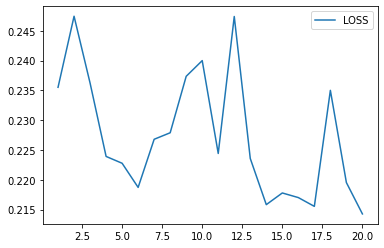

In [27]:
# LOG RESULTS

epochs_range = range(1, epochs + 1)
history_dict = history.history

loss = history_dict['loss']

plt.plot(epochs_range, loss, label="LOSS")

plt.legend()
plt.show()

## Prediction

1/1 [==============================] - 0s 116ms/step


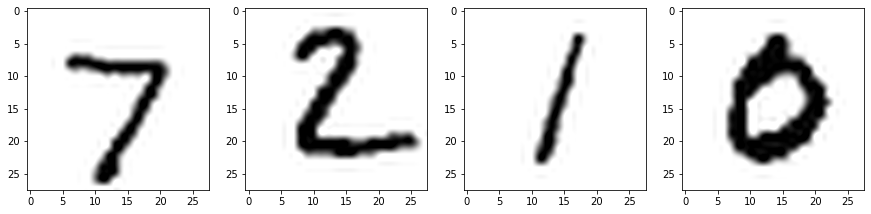

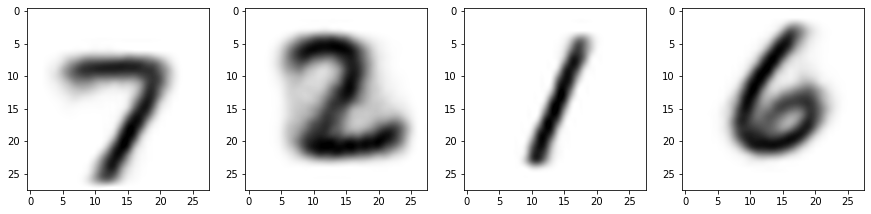

In [28]:
# The results of prediction - reality comparing to reconstructed images

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(test_images[:5])
x_reconst         = vae.decoder.predict(z)

# ---- Plot reality images

fig = plt.figure(figsize=(15,22))
for i in range(1, 5):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(test_images[i-1].reshape(28, 28), cmap='binary', interpolation='lanczos')

plt.show()

# ---- Plot reconstructed images

fig = plt.figure(figsize=(15,22))
for i in range(1, 5):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(x_reconst[i-1].reshape(28, 28), cmap='binary', interpolation='lanczos')

plt.show()

## Visualize latent space

313/313 [==============================] - 1s 2ms/step


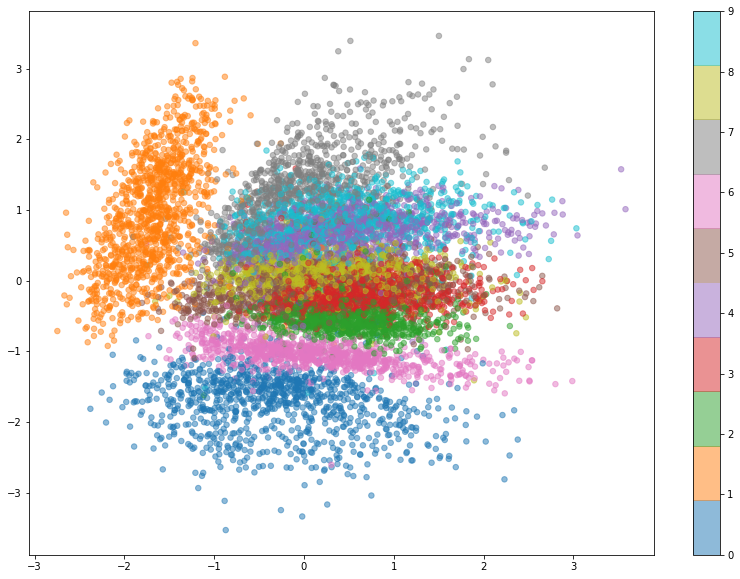

In [29]:
# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(test_images)

# ---- Show data representation in latent space

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=test_labels, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
plt.show()

## Reconstruct image with latent space coordinates

1/1 [==============================] - 0s 37ms/step


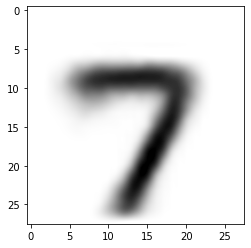

In [49]:
# Generate image with random coords

random_coords = np.array([(0, 2)])

x_reconstruct = vae.decoder.predict(random_coords)

plt.imshow(x_reconstruct[0].reshape(28, 28), cmap='binary', interpolation='lanczos')